# Localization 6

This is my implementation of the Localization part 6 lectures from Lazy Programmer's Deep Learning and Advanced Computer Vision course. In this section the task is made a bit harder by including images where there is no Pokemon.

This is achieved by increasing the number of outputs to 5 where the first 4 are top, left, height and width as before, and the fifth indicates whether or not there is a Pokemon in the scene. If there is, it should generate a value close to 1. If not, it should generate an output close to 0.

Code for this article can be found at [https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-6.ipynb](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-6.ipynb)

In [25]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image, ImageDraw

IMAGE_DIM = 200

I started with the final code from [Localization 5](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-5.ipynb) and then made the necessary modifications from there.

As in the previous exercise, I want the background image to be different in each image so I grabbed a landscape picture from Unsplash and then updated the LocalizationSequence to take 200x200 pixel sections from the image to use as a background.

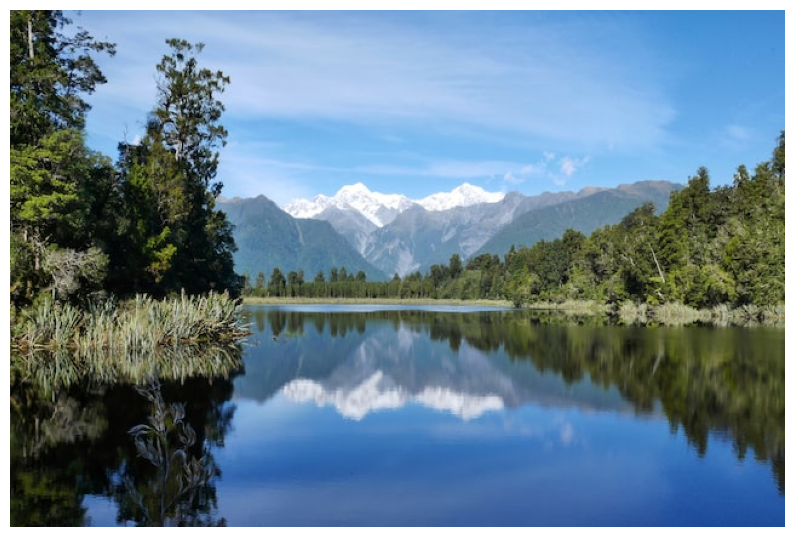

In [26]:
with Image.open('assets/images/landscape.png') as im:
    plt.axis('off')
    plt.imshow(im)

plt.show()

Photo by [Patrick Szylar](https://unsplash.com/@patrick_szylar?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on [Unsplash](https://unsplash.com/s/photos/outdoor?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)

The individual image backgrounds are taken by using the [`Image.crop()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop) function from the Pillow library.

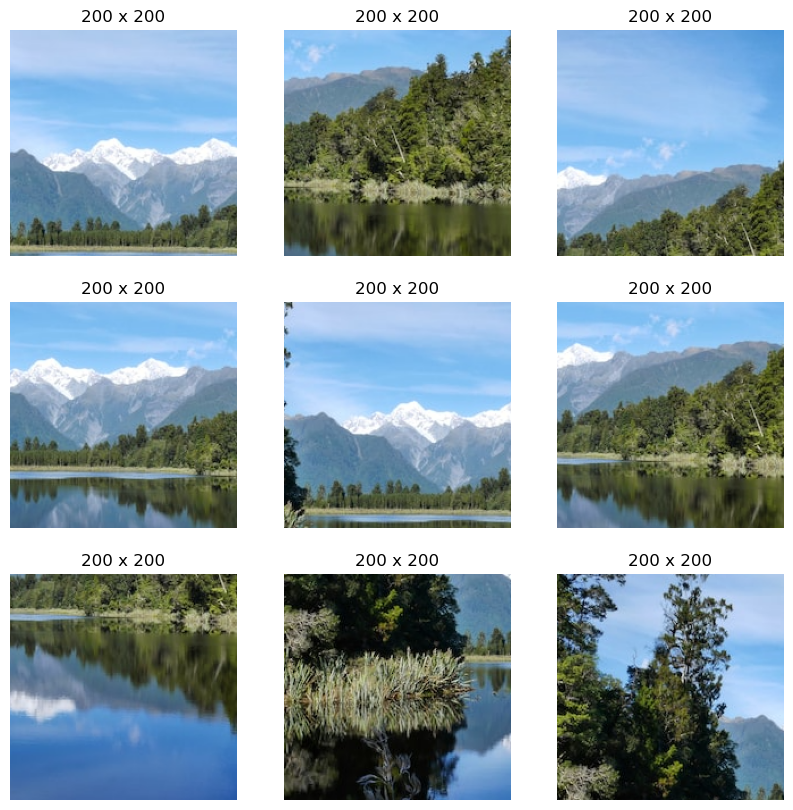

In [27]:
with Image.open('assets/images/landscape.png') as im:
    for i in range(1, 10):
        ax = plt.subplot(3, 3, i)
        left = random.randint(0, im.width - IMAGE_DIM)
        top = random.randint(0, im.height - IMAGE_DIM)
        cropped_im = im.crop((left, top, left + IMAGE_DIM, top + IMAGE_DIM))
        ax.imshow(cropped_im)
        ax.set_axis_off()
        ax.set_title(f'{cropped_im.width} x {cropped_im.height}')
 

plt.show()


To combine the Pokemon and background images together, as before, I used the [`Image.alpha_composite()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.alpha_composite) function from Pillow which ensures that the transparency is respected.

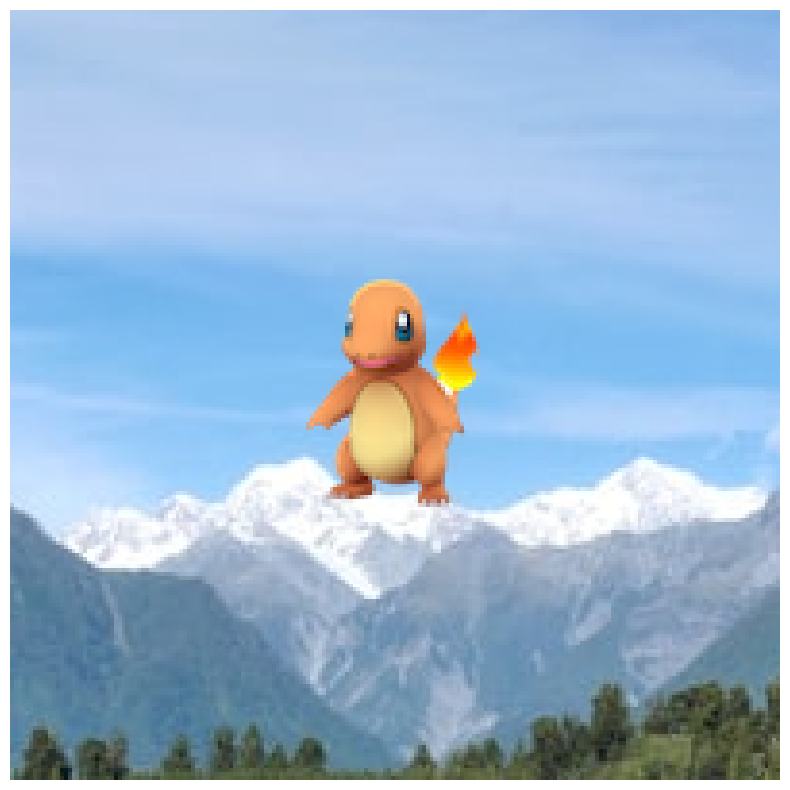

In [28]:
with Image.open('assets/images/landscape.png') as bg, \
     Image.open('assets/images/charmander.png') as im:

    left = random.randint(0, bg.width - IMAGE_DIM)
    top = random.randint(0, bg.height - IMAGE_DIM)
    cropped_bg = bg.crop((left, top, left + IMAGE_DIM, top + IMAGE_DIM))
 
    im_location = (
        int((IMAGE_DIM / 2) - (im.width / 2)), 
        int((IMAGE_DIM / 2) - (im.height / 2))
    )

    combined_image = cropped_bg.alpha_composite(im, dest=im_location)
    
plt.imshow(cropped_bg)
plt.axis('off')
plt.show()


In order to randomly generate some images with a Pokemon and some without, I updated the `generate_image()` function so that it only generates an image with a Pokemon in it 50% of the time.

In [30]:
class LocalizationSequence(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        with Image.open('assets/images/charmander.png') as im, \
             Image.open('assets/images/landscape.png') as bg:
                
            self.charmander = im.copy()
            self.background = bg.copy()
        
        
    def preprocess_y_value(self, y):
        """
        Sets the range of y to 0..1.
        """
        return y / IMAGE_DIM
        

    def generate_background(self):
        """
        Generates a background image by cropping out a part of the
        background image.
        """
        left = random.randint(0, self.background.width - IMAGE_DIM)
        top = random.randint(0, self.background.height - IMAGE_DIM)
        return self.background.crop((left, top, left + IMAGE_DIM, top + IMAGE_DIM))

        
    def generate_charmander(self):
        """
        Generates a Charmander pokemon of a random size from 0.5 to
        1.5 the scale of the original one and flipped left to right
        50% of the time.
        """
        scale = random.uniform(0.5, 1.5)
        poke = self.charmander.resize(
            (int(self.charmander.width * scale), 
             int(self.charmander.height * scale)))

        if random.random() > 0.5:
            poke = poke.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
            
        return poke
        
        
    def generate_image(self):
        """
        Generates a random image with a Charmander inside it. 
        """
        
        # start by generating the background
        img = self.generate_background()
                
        # generate the pokemon
        poke = self.generate_charmander()
        (char_width, char_height) = poke.size

        # place the charminder randomly in the image
        char_left = random.randint(0, img.width - char_width)
        char_top = random.randint(0, img.height - char_height)

        # don't always generate a pokemon
        include_charmander = 1. if random.random() > 0.5 else 0.

        if include_charmander == 1:
            # combine the two together
            img.alpha_composite(poke, dest=(char_left, char_top))
        
        # create a numpy array from the image and strip out the
        # alpha channel
        img_arr = np.array(img)[:, :, 0:3]
        
        # normalize colours
        img_arr = img_arr / 255.
        
        dims = self.preprocess_y_value(np.array([char_top, char_left, char_height, char_width]))
        
        return img_arr, np.append(dims, include_charmander)
        
        
    def __len__(self):
        """
        We generate the images on the fly so just return a high number.
        """
        return 1000
    
    
    def __getitem__(self, idx):
        """
        Return a batch of images preprepared for training. I.e. colour ranges
        are 0..1 and not 0..255.
        """
        batch_x = np.empty(
            [self.batch_size, IMAGE_DIM, IMAGE_DIM, 3], 
            dtype=np.float32
        )
        batch_y = np.empty([self.batch_size, 5], dtype=np.float32)
        
        for i in range(self.batch_size):
            batch_x[i], batch_y[i] = self.generate_image()
            
        return batch_x, batch_y
    


Let's test that out and see what it generates.

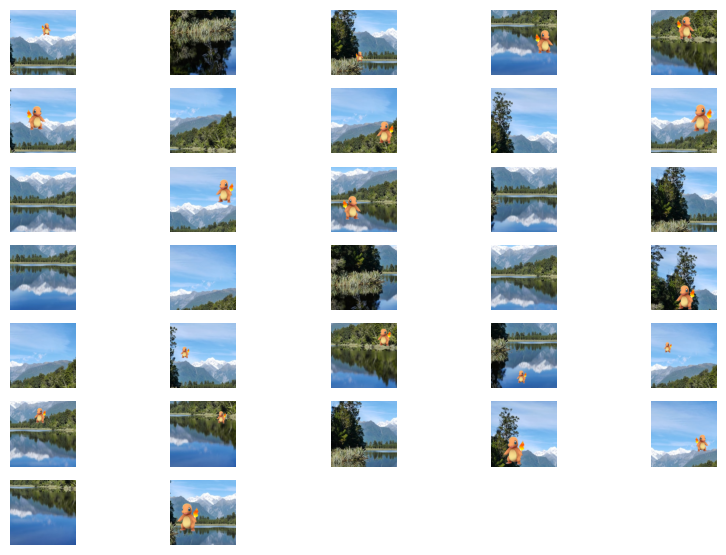

In [31]:
seq = LocalizationSequence(batch_size=32)
batch_x, batch_y = seq.__getitem__(0)

plt.rcParams["figure.figsize"] = (10, 10)
for i in range(min(50, seq.batch_size)):
    ax = plt.subplot(10, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(batch_x[i])
    
plt.show()


Now that we have one output representing the detection of a Pokemon and the others representing the location and size of a Pokenon if it is detected, we need a custom loss function. We need to only train for the location and size of a Pokemon if a Pokemon is detected. If no Pokemon is in the image, we don't care what the values of the position and size outputs are. 

As in Lazy Programmer's lecture, we also want to weight the relative importance of detecting a Pokemon vs locating it in the image. The custom loss function can therefore be given as:

$$ loss = W_{1}L_{bce}(Y_{[0..3]}, \hat{Y}_{[0..3]})Y_{[4]} + W_{2}L_{bce}(Y_{[4]}, \hat{Y}_{[4]})$$

Where:

&emsp;$W_{1}$ and $W_{2}$ are the weightings for the location and detect losses  
&emsp;$L_{bce}$ represets the binary crossentropy loss function  
&emsp;$Y_{[0..3]}$ and $\hat{Y}_{[0..3]}$ represent the actual and predicted location outputs  
&emsp;$Y_{[4]}$ and $\hat{Y}_{[4]}$ represent the actual and predicted detect outputs  

The way this works is that the weighted location and size outputs are multiplied by the detect outputs which are 1 if a Pokemon is present and 0 if not. Therefore the location and size are only included in the loss calculation when a Pokemon is in the scene.

The custom loss is created as a class derived from the Keras Loss class as shown in the Tensorflow documentation at [https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss)

In [56]:
class PokemonBinaryCrossEntropyError(tf.keras.losses.Loss):
    
    def __init__(self):
        super().__init__()
        self.binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
        self.weight_detect = .5
        self.weight_location = 3.
        
    def call(self, y_true, y_pred):
        position_loss = self.binary_crossentropy(y_true[:, :-1], y_pred[:, :-1])
        detect_loss = self.binary_crossentropy(y_true[:, -1], y_pred[:, -1])

        rv = self.weight_location * position_loss * y_true[:, -1] + \
            self.weight_detect * detect_loss
        
        return rv

As before, we're using the Adam optimizer.

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

Next we create the model as before.

In [37]:
# create the model
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3), 
    include_top=False, 
    weights='imagenet'
)

# we don't want to train the VGG16 model
vgg16.trainable = False

# create the dense layer
x = tf.keras.layers.Flatten()(vgg16.output)
x = tf.keras.layers.Dense(5, activation="sigmoid")(x)

# and build and compile it
model = tf.keras.Model(vgg16.input, x, name="Localization_Model")
model.compile(loss=PokemonBinaryCrossEntropyError(), optimizer=opt)
model.summary()

Model: "Localization_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)

Then we train the model using the image generator.

In [50]:
history = model.fit(seq, epochs=15, steps_per_epoch=50)

Epoch 1/15
50/50 [==============================] - 232s 5s/step - loss: 1.0121
Epoch 2/15
50/50 [==============================] - 261s 5s/step - loss: 0.9826
Epoch 3/15
50/50 [==============================] - 268s 5s/step - loss: 0.9862
Epoch 4/15
50/50 [==============================] - 265s 5s/step - loss: 0.9475
Epoch 5/15
50/50 [==============================] - 244s 5s/step - loss: 0.9305
Epoch 6/15
50/50 [==============================] - 238s 5s/step - loss: 0.9452
Epoch 7/15
50/50 [==============================] - 243s 5s/step - loss: 0.9318
Epoch 8/15
50/50 [==============================] - 544s 11s/step - loss: 0.9412
Epoch 9/15
50/50 [==============================] - 850s 17s/step - loss: 0.9418
Epoch 10/15
50/50 [==============================] - 861s 17s/step - loss: 0.9520
Epoch 11/15
50/50 [==============================] - 557s 11s/step - loss: 0.9513
Epoch 12/15
50/50 [==============================] - 276s 6s/step - loss: 0.9817
Epoch 13/15
50/50 [==============

Plot the accuracy from the `model.fit()`.

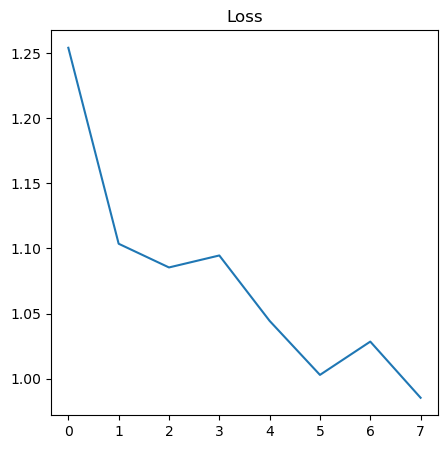

In [39]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.show()

Training can take some time so save out the model so it can be loaded from disk in future.

In [40]:
model.save('saved-models/localization-6.h5', overwrite=True)

The `to_pil_rect()` function takes the y outputs from the model and converts the values into the correct coordinates for the image. We only want to do that for the location and size values though, not for the detect values. We also have to convert width and height into right and bottom values by adding them to the left and top values.

In [41]:
def to_pil_rect(y):
    rv = np.copy(y)
    rv[:, :-1] = rv[:, :-1] * IMAGE_DIM
    rv[:, 2:4] = rv[:, 2:4] + rv[:, 0:2]
    return rv

The sequence object can be used to create a set of images we can use for prediction.

In [42]:
x, y = seq.__getitem__(0)

Use the trained model to make some predictions from the new batch.

In [43]:
y_predicted = model.predict(x)


1/1 [==============================] - 5s 5s/step


In [44]:
print(f'{y_predicted}')

[[0.33042088 0.3689972  0.2526434  0.19812489 0.3171983 ]
 [0.33219436 0.36800167 0.24466677 0.18667066 0.29756543]
 [0.359805   0.41614756 0.26361936 0.19685405 0.22400011]
 [0.37925586 0.13588879 0.21376795 0.18139058 0.91549164]
 [0.4407481  0.35627893 0.22687629 0.18955085 0.46615386]
 [0.505883   0.2647147  0.2535889  0.20555252 0.6938887 ]
 [0.34351763 0.4196634  0.2685253  0.21678808 0.12899807]
 [0.32773763 0.3766944  0.19479442 0.14552055 0.63485605]
 [0.4131647  0.4003464  0.25885642 0.18113205 0.14117031]
 [0.35696685 0.42993134 0.27670994 0.20781368 0.12176543]
 [0.06818602 0.5704579  0.4228405  0.32244375 0.9807152 ]
 [0.36277992 0.40696758 0.2844094  0.19866383 0.20561527]
 [0.38946462 0.15157318 0.37176487 0.25661403 0.9912611 ]
 [0.40049714 0.36840242 0.26106474 0.19900034 0.17627633]
 [0.5572099  0.5854852  0.28987008 0.21799481 0.68154   ]
 [0.31780773 0.27949628 0.2630223  0.16857657 0.48491472]
 [0.19189288 0.30574405 0.18613449 0.14544171 0.91930854]
 [0.6090784  0

Create the boxes for both the actual boxes and the predicted ones.

In [51]:
predicted_boxes = to_pil_rect(y_predicted)
actual_boxes = to_pil_rect(y)

Next we create a function that takes each of the images used in the predictions and adds the predicted bounding boxes. I did this using the Pillow library but it's probably pretty straightforward to use Numoy or tf functions to do it too.

In [52]:
def add_bounding_boxes():
    """
    Adds the bounding boxes to the images used in the prediction.
    """
    rv = np.zeros((seq.batch_size, IMAGE_DIM, IMAGE_DIM, 3), dtype=np.uint8)
    for i in range(seq.batch_size):
        im = Image.fromarray(np.uint8(x[i] * 255), mode='RGB')

        draw = ImageDraw.Draw(im)
        
        # add the bounding rectangle if something was detected
        if predicted_boxes[i][4] > 0.5:

            draw.rectangle(
                [predicted_boxes[i, 1], 
                 predicted_boxes[i, 0], 
                 predicted_boxes[i, 3], 
                 predicted_boxes[i, 2]], outline='green')
        
        rv[i] = np.array(im).astype(dtype=np.uint8)

    return rv

In [53]:
final_images = add_bounding_boxes()

Now we can draw some of the images that were used to create the predictions and overlay the localization rectangles on top of them as before.

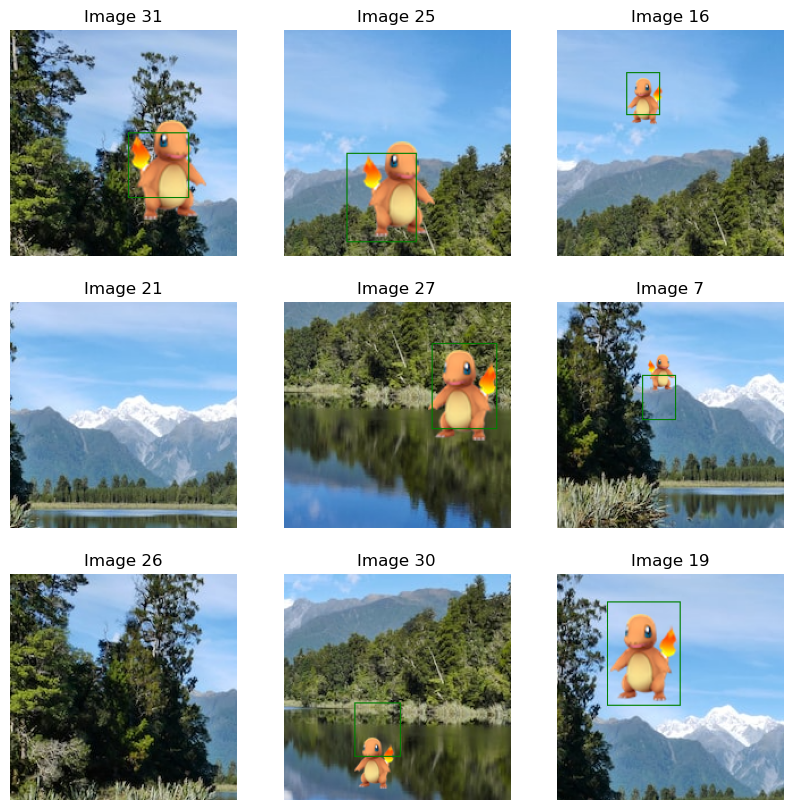

In [55]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im_idx = random.randint(0, seq.batch_size - 1)
    ax.imshow(final_images[im_idx])
    ax.set_axis_off()
    ax.set_title(f'Image {im_idx}')

In the output above you can see the green boxes that are the results of the predictions. You can see that some of the predictions are a bit off so it would require some more tweaking to improve it but it's a good start.